$\beta = -1$ means that $\beta$ is selected at random in each iteration.

In [1]:
import pandas as pd
from grasp_iters import read_results

# iters = read_results("rl1323_882_441_0_p44_a3")
# iters = read_results("rat783_522_261_0_p20_a2")
iters = read_results("rl1323_882_441_0_p20_a3")

In [2]:
iters

,iter,beta,RGD_OF,AFVS_OF,time,is_new_best
0,0,0.217888,5624,4180,6.555388,True
1,1,0.881793,7000,4495,9.334014,False
2,2,0.806632,6841,4304,13.462326,False
3,3,0.440826,6538,4252,17.854619,False
4,4,0.698069,5828,4327,22.075512,False
...,...,...,...,...,...,...
4995,4995,0.258762,7176,4304,16058.317987,False
4996,4996,0.236388,5918,4388,16061.272851,False
4997,4997,0.045704,5833,4327,16065.256414,False
4998,4998,0.892714,7211,4182,16069.853268,False


In [3]:
improvs = iters[iters["is_new_best"] == True].drop("is_new_best", axis=1)
improvs

,iter,beta,RGD_OF,AFVS_OF,time
0,0,0.217888,5624,4180,6.555388
9,9,0.938647,8196,4157,40.003975
66,66,0.854831,7517,4128,239.757502
76,76,0.376441,5727,4031,275.018968
180,180,0.221051,5932,4015,621.834342
3490,3490,0.409655,6261,3948,11237.421071


In [4]:
improvs.count()[0]

6

In [5]:
percents = improvs["AFVS_OF"].pct_change().mul(-100)
improvs.insert(loc=4, column="imp", value=percents)

iter_diffs = improvs["iter"].diff()
improvs.insert(loc=6, column="iwi", value=iter_diffs)

improvs

,iter,beta,RGD_OF,AFVS_OF,imp,time,iwi
0,0,0.217888,5624,4180,NaN,6.555388,NaN
9,9,0.938647,8196,4157,0.550239,40.003975,9.0
66,66,0.854831,7517,4128,0.697618,239.757502,57.0
76,76,0.376441,5727,4031,2.349806,275.018968,10.0
180,180,0.221051,5932,4015,0.396924,621.834342,104.0
3490,3490,0.409655,6261,3948,1.668742,11237.421071,3310.0


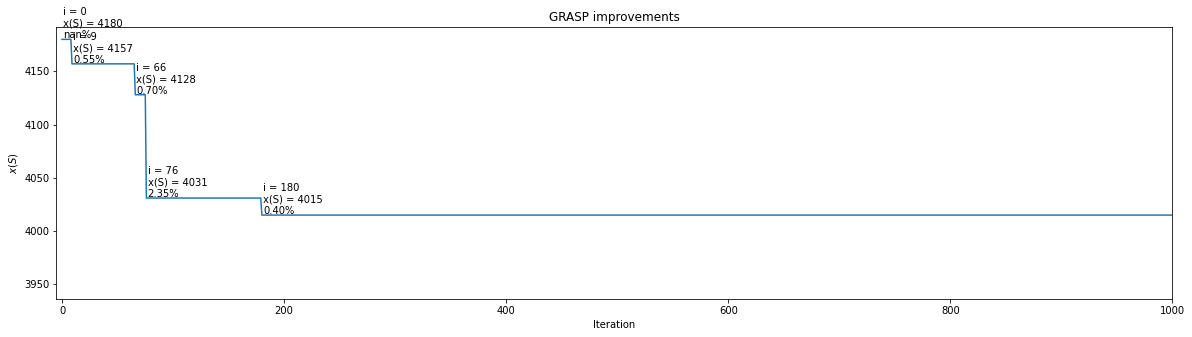

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

plt.plot(
    iters["iter"],
    iters["AFVS_OF"].cummin(),
)

for _, row in improvs.iterrows():
    of = int(row["AFVS_OF"])
    i = int(row["iter"])
    percent = row["imp"]

    plt.annotate(
        f"i = {i}\nx(S) = {of}\n{percent:.2f}%",
        (i, of),
        xytext=(i + 1, of + 1),
    )

plt.xlim(-5, 1000)
# plt.margins(0.001)
plt.title(f"GRASP improvements")
plt.ylabel("$x(S)$")
plt.xlabel("Iteration")

plt.show()